# 3주차, 5일차 : 코드 암기하기
- ### Contents 
    1. Better performance with the tf.data API: https://www.tensorflow.org/guide/data_performance
    2. Time Series Forecasting: https://www.tensorflow.org/tutorials/structured_data/time_series
    3. Text Classification with an RNN: https://www.tensorflow.org/tutorials/text/text_classification_rnn
    4. Distributed training with Keras: https://www.tensorflow.org/tutorials/distribute/keras

## 1. Better performance with the tf.data API
### 개요 
GPU와 TPU는 하나의 학습 단계를 실행하는데 필요한 시간을 급격하게 줄일 수 있습니다. <br>
최대 성능을 위해서는 현재 단계가 종료되기 전에 다음 단계의 데이터를 운반하는 효율적인 입력 파이프라인이 필요합니다.<br>
`tf.data` API는 유연하고 효율적인 입력 파이프라인을 만드는데 도움이 됩니다. 

- 텐서플로 입력 파이프라인이 기본적으로 ETL 프로세스라는 것을 설명합니다.
- 고성능 텐서플로 입력 파이프라인을 설계하기 위해 권장하는 방법을 설명합니다. 
- 변환 순서에 따른 성능 영향에 대해 설명합니다.

### 입력 파이프라인 구조
- 전형적인 텐서플로 훈련 입력 파이프라인은 ETL 프로세스로 구성될 수 있습니다.
    1. **추출**: 메모리(Numpy)나 로컬(HDD 또는 SSD)이나 원격(이를테면 GCS or HDFS) 영구 스토리지로부터 데이터를 읽어들입니다.
    2. **변환**: 분석하기 위해 CPU를 사용하여 셔플링, 배칭 그리고 압축 해제와 Augmentation, 텍스트 벡터화 또는 비디오 시간 샘플링과 같은 데이터 전처리를 수행합니다.
    3. **적재**: 변환된 데이터를 가속장치(들)에 적재합니다.

- 이 패턴은 CPU를 효과적으로 사용하면서 모델 훈련을 많이 수행하도록 가속기를 예비합니다. 게다가 입력 파이프라인을 ETL 프로세스로 보는 것은 성능 최적화를 쉽게 적용할 수 있는 프레임워크를 제공합니다.
- 아래 예제는 레이블된 이미지가 포함된 TFRecord 파일들을 읽고 이를 학습에 적합한 이미지-레이블 쌍의 배치(batch)로 변환하는 입력 파이프라인의 간단한 구현 입니다. 
- 입력 파이프라인은 `tf.data.Dataset`로 표현되고 `tf.keras`와 같은 고수준의 텐서플로 API에 전달될 수 있습니다.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import time

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

### The Dataset

In [2]:
'''
이번 가이드에서는 데이터셋과 성능 측정을 반복해서 번갈아 살펴볼텐데, 재현 가능한 성능 벤치마크는 다음과 같은 이유로 만들기 어려울겁니다.
1. 현재 CPU 부하
2. 네트워크 트레픽
3. 캐시 같은 복잡한 메커니즘에 의해서
그래서 재현 가능한 벤치마크를 위해 인공적인 데이터셋을 사용하겠습니다.
tf.data.Dataset을 상속받아 AritificialDataset이라는 클래스를 정의하겠습니다. 
이 데이터셋은 
- 'num_sample' 만큼 샘플을 생성합니다.
- 파일에서 첫번째 아이템이 시뮬레이션 하기 전까지 sleep 합니다.
- 각 아이템이 생성되어 파일로부터 데이터를 읽는 걸 시뮬레이션 하기 전까지 sleep 합니다.
'''

class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        #Opening the file
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            time.sleep(0.015)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )

### The training loop

In [3]:
'''
데이터셋 전체를 반복하기까지 얼마나 오래 걸리는지 측정하기 위한 더미 학습 루프를 작성합니다.
'''
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performong a training |
            time.sleep(0.01)
    tf.print('Execution time:', time.perf_counter() - start_time)

### Optimize performance
- 어떻게 성능이 최적화 될 수 있는지 보여주기 위해, `ArtificialDatast`의 성능을 향상시켜보겠습니다.

#### The naive approach
- 트릭 없이 나이브한 파이프라인으로 시작해봅니다. as-is 데이터셋을 반복시켜봅니다.

In [4]:
benchmark(ArtificialDataset())

Execution time: 0.22904720900078246


- 실행 시간이 이런식으로 수행되었었다.

<img src= https://www.tensorflow.org/guide/images/data_performance/naive.svg/ >

- Training step에 포함 되어 있는 것들
    1. 아직 열리지 않은 파일을 열기
    2. 파일로부터 데이터 엔트리 가져오기
    3. 학습에 데이터 사용하기
    
- 하지만 이러한 동기화된 구현은, 파이프라인이 데이터를 불러오는 동안, 모델은 유휴 상태에 있게됩니다. 반대로 모델이 학습하는 동안에는 입력 파이프라인이 유휴상태에 있게 됩니다. 학습 과정 시간은 이러한 것들의 합입니다. 파일 열기, 읽기, 학습 시간
- 다음에는 입력 파이프라인에는 최적으로 디자인된 텐서플로우 입력 파이프라인 수행자를 사용해보겠습니다. 

### Prefetching
- Prefetching은 전처리와 모델 학습 수행을 겹치도록 하는 것입니다. 모델이 학습을 수행하는 동안 입력 파이프라인은 데이터를 읽어옵니다. 이렇게하면, 학습하는 시간과 추출하는 시간을 최대한 줄일 수 있습니다. 

In [5]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Execution time: 0.18462495899984788


<img src=https://www.tensorflow.org/guide/images/data_performance/prefetched.svg />

이제 샘플 0에 대해 학습하고 있을 때, 입력 파이프라인은 샘플 1 데이터를 읽고 있습니다. 

### Parallelizing data extraction 
- 실제 세계에서는, 입력 데이터는 원격에 저장되어 있습니다. 데이터셋 파이프라인은 로컬에서 데이터를 읽을 때 좋습니다. 만약에 데이터가 원격 저장소에 있다면 I/O 병목 현상이 일어나게 됩니다. 이러한 현상은 로컬 원격 저장소의 차이점에 의해 생깁니다.
    - Time-to-first-byte: 파일의 첫번째 바이트 부터 읽는 것은 원격 저장소가 로컬 저장소보다 오래 걸립니다. 
    - Read throughput: 원격 저장소가 일반적으로 넓은 대역폭을 제공하더라도, 단일 파일을 읽는 것은 대역폭의 작은 부분만 활용합니다.
    - 여러가지 데이터 추출 오버헤드를 완화 하기 위해, `tf.data.Dataset.interleave` 전송을 병렬적으로 사용할 수 있습니다. 

In [6]:
benchmark(tf.data.Dataset.range(2)
         .interleave(ArtificialDataset))

Execution time: 0.18872581600044214


- 다음 그림은 `interleave` 전송을 보여줍니다. 하지만 성능 향상이 포함되지는 않았습니다.
<img src=https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg />

#### 병렬 인터리브
- 이제 `num_parallel_calls` 파라미터를 사용하겠습니다. 다중 데이터셋을 병렬적으로 불러옵니다,

In [7]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        ArtificialDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.1285446050005703


<img src=https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg />
- 이제야 두개의 데이터셋을 병렬적으로 읽어올 수 있었습니다. 전체 데이터 처리 시간을 줄였습니다.

### 데이터 변환 병렬화하기
- 데이터를 준비할 때, 입력 성분은 전처리가 필요할 수 있습니다. `tf.data`API는 `tf.data.Dataset.map` 변환을 제공하며, 유저-정의 함수를 각 원소에 적용할 수 있습니다. 
- 각 데이터셋 원소는 서로 독립적이기 때문에 이러한 전처리는 다중 GPU를 통해 병렬적으로 처리할 수 있습니다. 
- 이는 `prefetch`와 `interleave` 변환과 비슷하게 가능하도록 만들 수 있습니다.
- `map` 변환은 병렬 수준을 지정할 수 있는 `num_parallel_call` 인수를 제공합니다.

In [8]:
def mapped_function(s):
    # 하드 전처리를 진행합니다.
    tf.py_function(lambda: time.sleep(0.04), [], ())
    return s

#### Sequential Mapping
- 병렬화 없이 `map` 변환을 사용해보겠습니다.

In [9]:
benchmark(ArtificialDataset()
         .map(mapped_function))

Execution time: 0.4720672410003317


<img src= https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg />
- 나이브한 접근으로 단일 이터레이션에 대한 열기, 읽기, 전처리 그리고 학습에 대한 전체 수행 시간이 나와있습니다.

#### Parallel mapping
- 그럼 이제 다중 샘플에 같은 전처리 함수를 병렬적으로 적용하겠습니다.

In [10]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.26787743999921076


<img src=https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg />
- 이제 전처리 단계가 겹쳐져 단일 이터레이션의 전체 시간이 줄어든 것을 확인할 수 있습니다.

#### Caching
`tf.data.Dataset.cache` Transformation은 데이터셋을 캐싱할 수 있습니다. 또는 메모리에 올려둘 수 있습니다.<br>
이러한 캐싱은 각 에폭이 수행되어지는 동안 파일을 열거나 데이터를 읽는 연산을 줄여줄 수 있습니다.

In [11]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function
    ).cache(
    ), 5
)

Execution time: 0.37327773600009095


데이터셋을 캐시할 때, 캐시 이전의 변환은 첫 에폭에 한번만 수행됩니다. 다음 에폭에서는 `cache` 변환에 의해 캐시된 데이터를 재사용 합니다. <br>
`map` 함수에 의한 변환이 비용이 많이 든다면 `cache` 변환을 통해 결과 데이터셋이 메모리나 로컬 저장소에 있도록 하세요.<br>
만약에 사용자 정의 함수가 캐시 용량을 넘어서 데이터 셋에 더 많은 공간을 요구한다면, `cache` 연산 이후에 사용자 정의 함수나 전처리를 적용해보세요. 

#### Vectorizing mapping
사용자 정의 함수를 `map` 함수를 통해 호출하는건 스케쥴링이나 해당 함수를 수행하는 부분에 대해 많은 오버헤드가 소요됩니다.<br>
그래서 사용자 정의 함수를 벡터화 (한번에 입력에 적용) 하는 것을 추천합니다. 

<br>

연습해보기 위해 현재 데이터셋은 스케줄링 지연이 10ms 이므로 적절하지 않기 때문에 10ms 보다 더 적은 데이터셋을 만들겠습니다.

In [12]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print('Execution time:', time.perf_counter() - start_time)
    
def increment(x):
    return x+1

#### Scalar mapping

In [13]:
fast_benchmark(
    fast_dataset
    # 한번에 전체에 대해 함수를 적용
    .map(increment)
    # Batch를 지정
    .batch(256)
)

Execution time: 0.38191625099898374


<img src=https://www.tensorflow.org/guide/images/data_performance/scalar_map.svg />

어떤식으로 돌아가는지 위에 플랏이 설명해줍니다. 살펴보면 맵 함수가 각 샘플들에 대해 적용되어짐을 확인할 수 있습니다.<br>
함수는 매우 빠른 반면에, 이러한 부분이 시간적인 성능에 대해 큰 영향을 미치는 오버헤드를 가지게 됩니다.
(중간중간 함수를 계속 호출해서 사용하기 때문에 오버헤드가 발생한다. 그러니 전체에 한번에 적용하자)

#### Vectorized mapping

In [14]:
fast_benchmark(
    fast_dataset
    .batch(256)
    .map(increment)
)

Execution time: 0.01401658700160624


<img src=https://www.tensorflow.org/guide/images/data_performance/vectorized_map.svg />
이번에는 맵 함수가 한번만 호출되었습니다. 반면에 함수는 조금 더 시간이 걸렸습니다. 오버헤드는 단 한번만 보여졌으며, 전체 시간 성능을 향상시켰습니다.

#### Reducing memory footprint
`interleave`, `prefetch` 그리고 `shuffle`을 포함하는 몇몇의 변환은 원소에 대한 내부 버퍼를 유지합니다.<br>
맵 변환에 전달된 사용자 정의 함수가 원소의 크기를 변경하면, 맵 변환의 순서와 원소를 버퍼링 하는 변환은 메모리 사용량에 영향을 줍니다.<br>
일반적으로 성능에 다른 순서를 지정하지 않는한, 적은 메모리를 사용하는 결과 순서를 추천합니다.

    dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
    
이 방법에서, 시간이 소요되는 부분은 첫번째 에폭에 연산이 된다. 그러면 많은 캐시 공간을 사용하는 것을 피할 수 있다.

#### Best practice summary
Tensorflow 입력 파이프라인을 가장 좋게 사용하는 방법은
- `prefetch` 변환을 사용하라. 생산자와 소비자의 작업을 겹치게 할 수 있다.
- 데이터 읽는 변환을 병렬화 하라. `interleave` 변환을 사용하면 된다.
- `map` 변환을 병렬화 하라. `num_parallel_calls` 인자를 세팅하면 된다.
- `cache` 변환을 사용하라. 첫 에폭에서 메모리에 데이터를 캐싱한다.
- 사용자 변환 함수를 벡터화 하여 `map` 변환을 전달해라.
- `interleave`, `prefetch`, `shuffle` 변환을 적용할 때 메모리 사용량을 줄여라. 

### Reproducing the figures

In [15]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
# the dataset, Similar to the ArticialDataset

In [17]:
class TimeMeasuredDataset(tf.data.Dataset):
    # Output: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()
    _EPOCHS_COUNTER = defaultdict(itertools.count)
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter
        
        for sample_idx in range(num_samples):
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter
            
            yield(
                [('Open',), ('Read',)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1. # 음수 값은 필터링 될거다.
            
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

In [18]:
# The iteration loop
def timelined_benchmark(dataset, num_epochs=2):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            steps_acc = tf.concat((steps_acc, [['Train']]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
            
        epoch_elapsed = time.perf_counter() - epoch_enter
        
        steps_acc = tf.concat((steps_acc, [['Epoch']]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
        
    tf.print('Execution time:', time.perf_counter() - start_time)
    return {'steps': steps_acc, 'times':times_acc, 'values':values_acc}
    

In [19]:
# The plotting method
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [20]:
# User wrappers for mapped function
def map_decorator(func):
    def wrapper(steps, times, values):
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

In [21]:
# Pipelines comperison
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

In [22]:
# Naive
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001) # 시간 소비 단계
    time.sleep(0.0001) # 메모리 소비 단계]
    map_elapsed = time.perf_counter() - map_enter
    
    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )
naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

Execution time: 11.851898353999786


In [23]:
# Optimized
@map_decorator
def time_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0]) # 시간 소비 단계
    map_elapsed = time.perf_counter() - map_enter
    
    return (
        tf.concat((steps, tf.tile([[['1st map']]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]],[times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

@map_decorator
def memory_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0]) # 메모리 소비 단계
    map_elapsed = time.perf_counter() - map_enter
    
    return (
        tf.concat((steps, tf.tile([[['2nd map']]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]],[times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        dataset_generator_fun,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(
        _batch_map_num_items,
        drop_remainder=True)
    .map(time_consumming_map,
         num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .cache()
    .map(
        memory_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 6.112098014000367


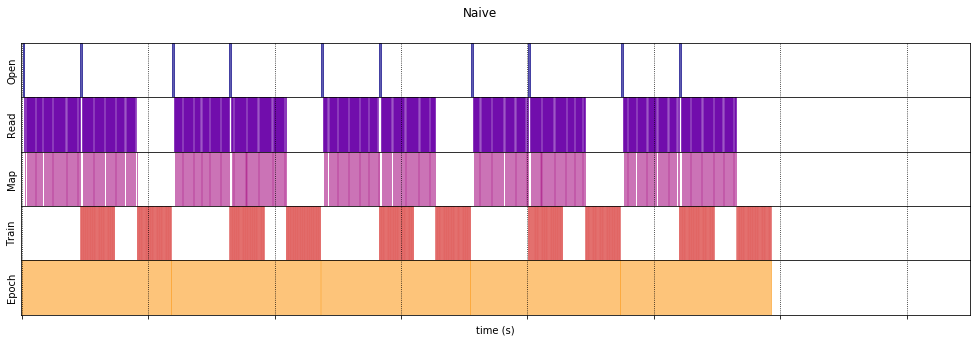

In [24]:
draw_timeline(naive_timeline, 'Naive', 15)

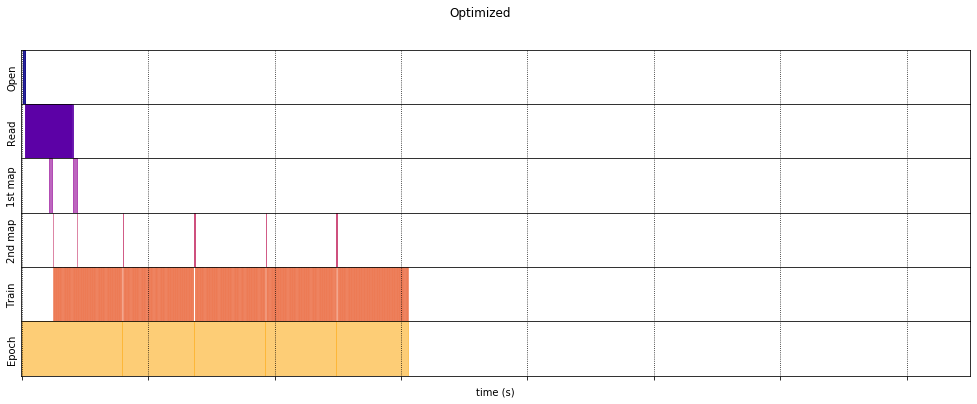

In [25]:
draw_timeline(optimized_timeline, 'Optimized', 15)

## 2. Time Series Forecasting
### 개요
이 튜토리얼은 RNN 모델을 사용한 시계열 예측 소개입니다. 2개의 파트로 이루어져 있으며, 첫 번째 파트는 단변수 시계열 예측이고, 두 번째 파트로는 다변수 시계열 예측입니다.

In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals
# import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False


### The weather datast
이번 튜토리얼에서는 시계열 날씨 데이터셋을 사용하려고 합니다. 
<br>
해당 데이터셋은 14개의 다른 변수가 존재합니다. 기온, 기압, 습도 등으로 이루어져 있습니다.<br>
2003 년부터 매 10분마다 수집되었습니다. 효율적인 튜토리얼을 위해 2009년 ~ 2016년 사이에 수집된 데이터만을 사용하겠습니다.

In [27]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [28]:
df = pd.read_csv(csv_path)

In [29]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


위에서 볼 수 있듯이 매 관측치는 10분마다 기록되었습니다. 이것은 한시간에 6개의 관측치가 있음을 의미하며, 비슷하게 매일 144개의 관측치를 포함하고 있음을 의미합니다.
<br><br>
주어진 특정한 시간에 대해 6시간 후 기온을 예측한다 생각해봅시다. 예측 값을 만들기 위해 우리는 5일치의 관측치를 선택합니다. 따라서 우리는 학습 모델에 지난 720(5 * 144)개의 관측치를 적용할 수 있는 윈도우를 만들어야 합니다. 더 많은 구성요소가 가능하므로 데이터셋을 실험하기에 좋습니다.
<br><br>
아래의 함수는 위에서 설명한 모델이 학습하기 위한 시간 윈도우를 반환합니다.<br>
`history_size` 파라미터는 지난 과거 정보에 대한 윈도우 크기입니다. `target_size` 파라미터는 미래에 모델이 예측을 배우는데 필요한 거리입니다. `target_size`는 예측하기 위해 필요한 라벨입니다.

In [30]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # (history_size,)로 이루어진 벡터를 (history_size, 1) 행렬로 변환
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [31]:
# 학습 데이터셋으로 앞 30만 행을 사용합니다. 나머지는 검증 데이터로 사용합니다. 대충 2100일에 해당하는 정도의 데이터입니다.
TRAIN_SPLIT = 300000

In [32]:
tf.random.set_seed(2019)

### Part 1: Forecast a univariate time series
첫 번째로, 단일 변수(온도)를 사용해 모델을 학습시키겠습니다. 그리고 해당 모델을 사용해 미래의 값에 대한 예측을 만들겠습니다.

In [33]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb42aeeb8>],
      dtype=object)

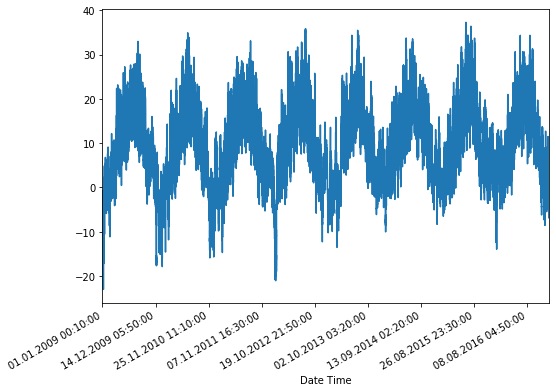

In [34]:
# 시간이 지남에 따라 데이터가 어떤식으로 관측되는지 확인해봅니다.
uni_data.plot(subplots=True)

In [35]:
uni_data = uni_data.values

변수의 스케일을 조절하는 것은 신경망을 학습하기 이전에 수행해야하는 중요한 부분입니다. 표준화(Standardizaion)은 일반적인 방법으로 평균을 빼고, 표준편차로 나누는 방식으로 스케일을 조정합니다. <br>
`tf.keras.utils.normalize` 함수를 사용해 값의 범위를 [0, 1]로 지정할 수 있습니다.
<br><br>
#### 주의: 평균과 표준편차는 반드시 훈련 데이터를 사용해 계산해야합니다.

In [36]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [37]:
# 표준화 합니다.
uni_data = (uni_data - uni_train_mean) / uni_train_std

In [38]:
# 단일 변수 모델을 만들어보겠습니다. 모델에 지난 20개의 기온 레코드가 주어지며,
# 다음 기온을 예측하기 위해 학습하는 것이 필요합니다.
univariate_past_history  = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                          univariate_past_history,
                                          univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                      univariate_past_history,
                                      univariate_future_target)

In [39]:
# 이것이 'univariate_data' 함수의 반환 값입니다.
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [40]:
# 이제 데이터가 만들어졌으니, 예제를 하나 살펴보겠습니다. 
# 네트워크에 주어진 정보는 파란색입니다. 그리고 빨간색 십자가의 값을 반드시 예측해야 합니다.
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [41]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/home/kyle/kyle/lib/python3.6/site-packages/matplotlib/pyplot.py'>

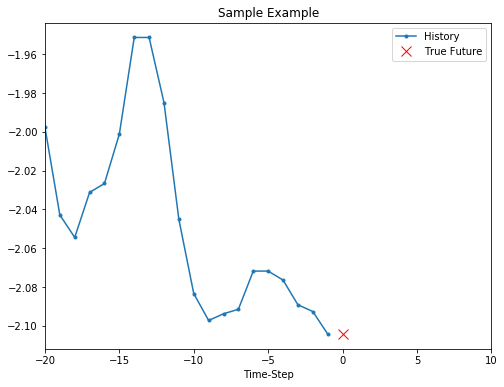

In [42]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
모델 학습흘 진행하기 전에, 간단한 베이스라인을 지정해 봅시다. 주어진 입력 포인트에 베이스라인 메소드는 지난 20개 관측치의 평균을 다음 포인트의 모든 히스토리에 대한 예측으로 사용합니다.

In [43]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/home/kyle/kyle/lib/python3.6/site-packages/matplotlib/pyplot.py'>

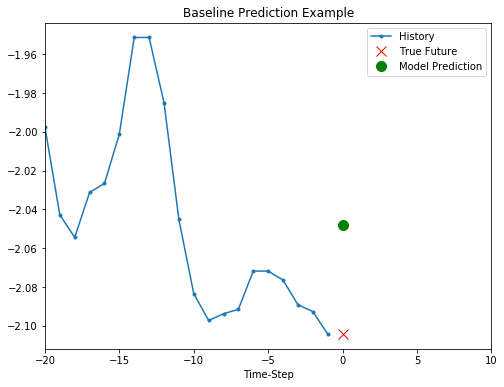

In [44]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
         'Baseline Prediction Example')

### Recurrent Neural Network
순환 신경망은 시계열 데이터에 매우 적합한 뉴럴 네트워크의 일종입니다. RNN은 시계열 데이터를 순차적으로 진행하며, 내부 상태 정보를 합하여 오랫동안 유지하게 됩니다. 이번 튜토리얼에서는 특화된 RNN 레이어인 Long Short Term Memory(LSTM)도 다룰 예정입니다.

In [45]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

배치 후에 데이터셋이 어떤식으로 표현되는지 이해하기 쉽도록 그림을 보겠습니다.

<img src=https://www.tensorflow.org/tutorials/structured_data/images/time_series.png />

LSTM은 주어진 데이터의 입력 차원을 요구합니다.

In [46]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [47]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [48]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


모델을 학습해보겠습니다. 데이터셋의 크기가 크므로 전체 데이터를 학습하는 것이 아니라 시간을 줄이기 위해 각 에폭은 200 스텝만 실행합니다.

In [49]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3088 - val_loss: 0.0482
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0650 - val_loss: 0.0283
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0412 - val_loss: 0.0243
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0365 - val_loss: 0.0219
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0258 - val_loss: 0.0199
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0277 - val_loss: 0.0192
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0178
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0242 - val_loss: 0.0171
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0166
Epoch 10/10
200/200 [==============================] - 1s

#### 단일 변수 LSTM 모델을 사용한 예측
학습이 끝났으니, 몇개 예측값을 뽑아보겠습니다.


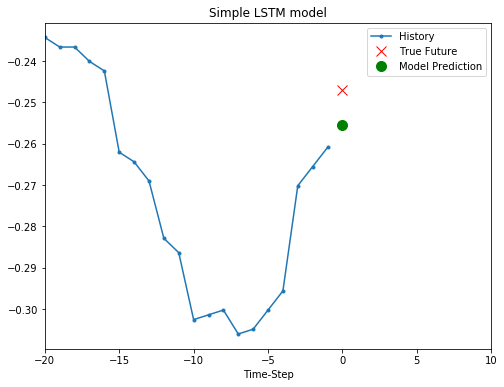

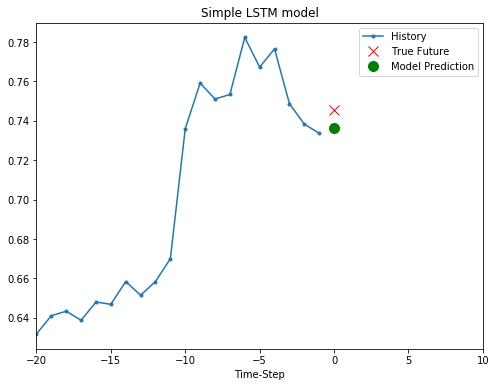

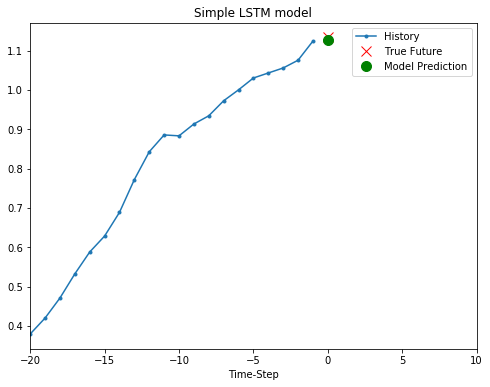

In [50]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

베이스라인 보다는 더 나은 결과로 보입니다. 이제 기본기를 해봤으니 두 번째 파트로 넘어가보겠습니다. 다중 변수를 사용한 시계열 예측입니다.

### Part 2: Forecast a multivariate time series
원본 데이터셋은 14개의 변수를 포함하고 있습니다. 간단하게 이번에는 14개 변수중 3개 변수를 사용하겠습니다.<br>
사용할 변수는 기온, 기압, 공기 밀도 입니다.
<br><br>
더 많은 변수를 사용할 수 있도록, 변수 이름을 리스트로 만들겠습니다.

In [51]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [52]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd946ca278>,
      dtype=object)

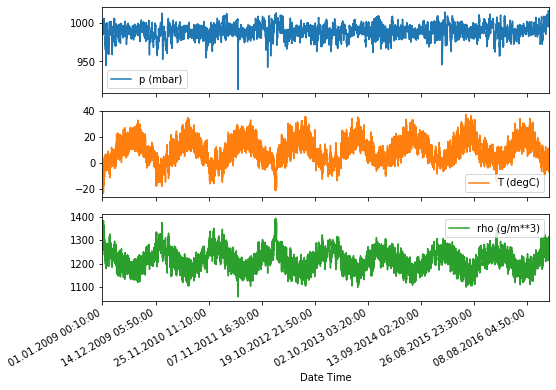

In [53]:
features.plot(subplots=True)

첫 번째 파트에서 이야기 했듯이 데이터의 평균과 표준편차를 이용해 표준화를 진행합니다.

In [54]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std  = dataset[:TRAIN_SPLIT].std(axis=0)

In [55]:
dataset = (dataset-data_mean)/data_std

### Single Step model
모델은 제공되는 몇개의 히스토리를 기반으로 미래의 점을 예측하는 것을 학습합니다.<br>
다음 함수는 윈도우 태스크를 수행합니다. 하지만, 주어진 단계 크기를 기반으로 과거 관측치를 샘플링합니다.

In [56]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                     target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

이번에도 모델에게 5일치 데이터를 보여줄겁니다. 그런데 매일 한시간마다 극적인 변화는 예측되지 않으므로 한시간에 한번으로 샘플링 하려고 합니다. 따라서 지난 5일에 대해 120개의 관측치가 존재합니다. Single Step 예측 모델의 라벨은 12시간 후의 미래 온도입니다. 이러한 라벨을 생성하기 위해, 온도는 72 관측치 이후의 것이 사용됩니다.

In [57]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP,
                                                  single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT,
                                              None, past_history,
                                              future_target, STEP,
                                              single_step=True)

In [58]:
print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [59]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [60]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                          input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mae')

In [61]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [62]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                           validation_data=val_data_single,
                                           validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3707 - val_loss: 0.2668
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2711 - val_loss: 0.2449
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2632 - val_loss: 0.2528
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2605 - val_loss: 0.2504
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2270 - val_loss: 0.2424
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2429 - val_loss: 0.2661
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2466 - val_loss: 0.2704
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2460 - val_loss: 0.2527
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2488 - val_loss: 0.2509
Epoch 10/10
200/200 [==============================] - 1

In [63]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

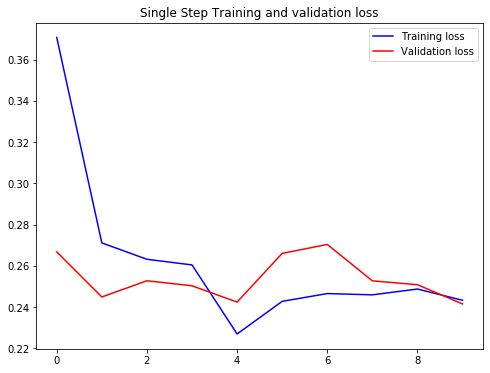

In [64]:
plot_train_history(single_step_history,
                  'Single Step Training and validation loss')

#### Single step future 예측해보기
모델을 학습했으니, 예측값을 확인해보겠습니다.

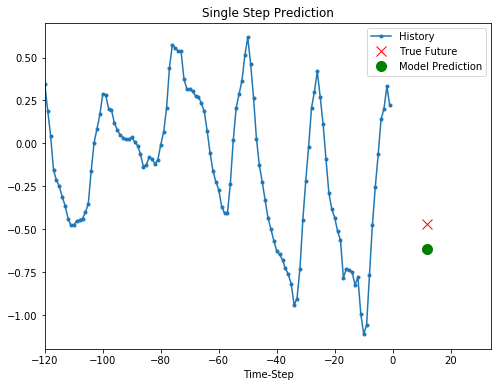

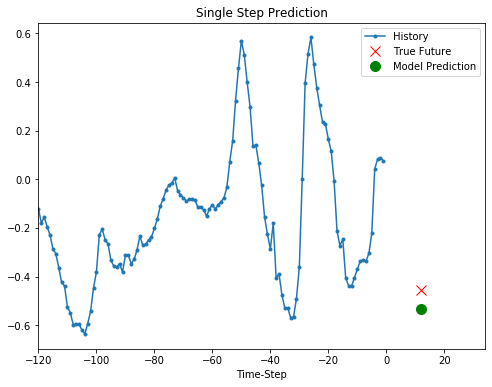

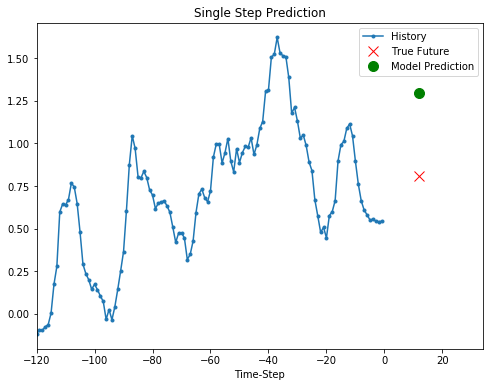

In [65]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                     single_step_model.predict(x)[0]], 12,
                    'Single Step Prediction')
    plot.show()

### Multi-Step model
이번에는 Multi-step 예측 모델입니다. 이전에는 단일 포인트를 예측하는 것이였다면, 이번에는 미래의 시퀀스를 예측하는 것이 목표입니다.<br><br>
Multi-step 모델에서는 훈련 데이터가 매 시간 샘플링된 지난 5일에 대한 데이터를 포함하고 있습니다. 하지만 이번에는 다음 12시간 후의 기온을 예측하는 것을 목표로합니다.<br>
그래서 매 10분마다 관측치가 존재하며, 출력은 72개의 값이 됩니다. 이 작업을 위해서는 데이터 셋을 적절히 준비해야하므로 첫 번째 단계는 다시 target 윈도우를 사용하여 다시 생성합니다.

In [66]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                TRAIN_SPLIT, past_history,
                                                future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT,
                                            None, past_history,
                                            future_target, STEP)

In [67]:
print('Single window of past histoty : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past histoty : (120, 3)

 Target temperature to predict : (72,)


In [68]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [69]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
            label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

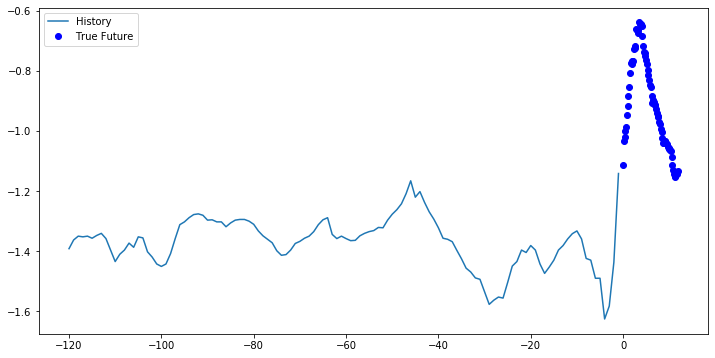

In [70]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

이 테스크는 이전의 테스크보다는 더욱 복잡하기 때문에, 모델에 두개의 LSTM 층을 포함 시키겠습니다. <br>
결과적으로 72개 예측값은 만드어질 것이고, Dense 레이어는 72개의 예측값을 출력합니다.

In [71]:
input_tensor = tf.keras.layers.Input(shape=x_train_multi.shape[-2:])
x = tf.keras.layers.LSTM(32, return_sequences=True)(input_tensor)
x = tf.keras.layers.LSTM(16, activation='relu')(x)
output_tensor = tf.keras.layers.Dense(72)(x)

multi_step_model = tf.keras.models.Model(input_tensor, output_tensor)

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [72]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 72)


In [73]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                         steps_per_epoch=EVALUATION_INTERVAL,
                                         validation_data=val_data_multi,
                                         validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 14s 72ms/step - loss: 0.5084 - val_loss: 0.2834
Epoch 2/10
200/200 [==============================] - 12s 62ms/step - loss: 0.3282 - val_loss: 0.2635
Epoch 3/10
200/200 [==============================] - 12s 62ms/step - loss: 0.2834 - val_loss: 0.2369
Epoch 4/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2330 - val_loss: 0.2060
Epoch 5/10
200/200 [==============================] - 13s 63ms/step - loss: 0.1978 - val_loss: 0.2124
Epoch 6/10
200/200 [==============================] - 12s 62ms/step - loss: 0.2055 - val_loss: 0.2112
Epoch 7/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2005 - val_loss: 0.2079
Epoch 8/10
200/200 [==============================] - 12s 62ms/step - loss: 0.1961 - val_loss: 0.1941
Epoch 9/10
200/200 [==============================] - 13s 63ms/step - loss: 0.1984 - val_loss: 0.1945
Epoch 10/10
200/200 [==================

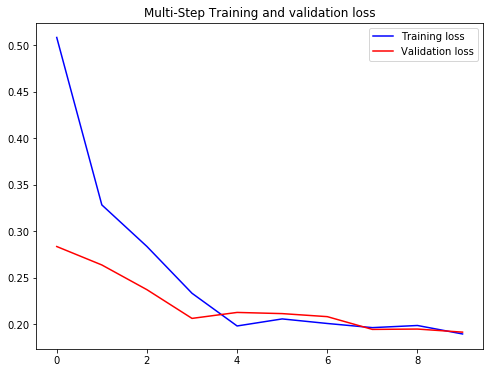

In [74]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

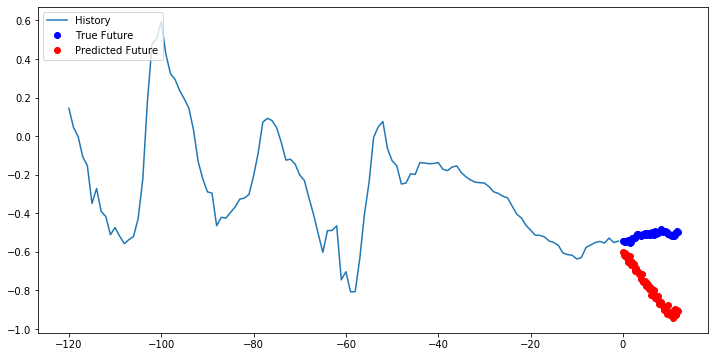

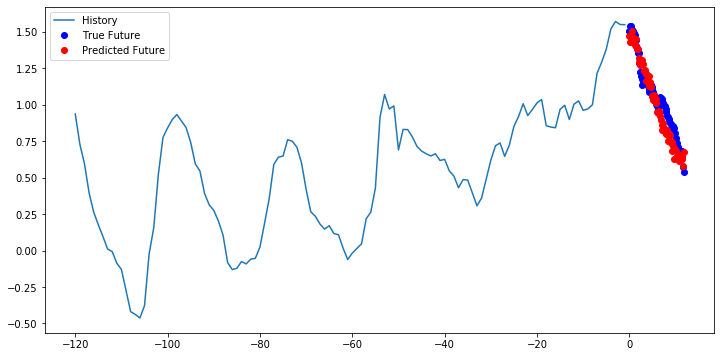

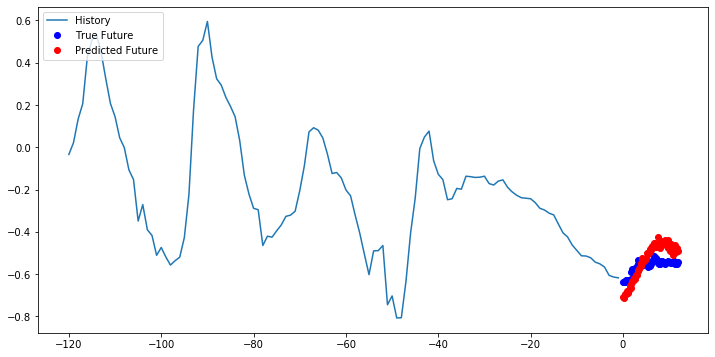

In [75]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## 3. Text Classification with an RNN

### Setup

In [76]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
# import tensorflow as tf

In [77]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### Setup input Pipeline
IMDB 영화 리뷰 데이터셋은 이진 분류 문제입니다. 모든 리뷰는 양수 혹은 음수 반응을 가지고 있습니다.

In [78]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                         as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset 'info'는 인코더를 포함하고 있습니다. `tfds.featrues.text.SubwordTextEncoder`

In [79]:
encoder = info.features['text'].encoder

In [80]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [81]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The oricial string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The oricial string: "Hello TensorFlow."


In [82]:
assert original_string == sample_string

In [83]:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### Prepare the data for traning
다음은 인코딩 된 문자열의 batch를 생성하겠습니다. `padded_batch` 를 사용해서, 나머지를 0으로 채워 모든 sequence의 길이를 동일하게 하겠습니다.

In [84]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [85]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

### Create the model
임베딩 레이어로 시작되는 `tf.keras.Sequential` 모델을 만들겠습니다. 임베딩 레이어는 하나의 단어에 하나의 벡터를 저장하고 있습니다. 임베딩 레이어가 호출되면, 단어 시퀀스가 벡터 시퀀스로 변환됩니다. 이러한 벡터는 학습이 가능합니다. 학습 이후에는 단어들은 비슷한 의미끼리는 비슷한 벡터를 가지게 됩니다.
<br><br>
이러한 index-lookup는 `tf.keras.layers.Dense`레이어에 원핫 인코딩된 벡터를 통과시키는 연산보다 더욱 효율적입니다.
<br><br>
RNN 모델은 원소를 반복적으로 통과시키는 것으로 시퀀스 입력을 처리합니다. RNN은 출력을 한 단계에서 입력으로 전달한 후에 다음 단계로 전달합니다.
<br><br>
`tf.keras.layers.Bidirectional` wrapper는 RNN 계층에 사용될 수 있는데, 이것은 입력을 앞뒤로 전파 한 다음 출력을 연결합니다. 이러한 방식은 모델이 긴 범위의 의존성을 배우도록 도와줍니다.

In [86]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [87]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

### Train the model

In [88]:
history = model.fit(train_dataset, epochs=10,
                   validation_data=test_dataset,
                   validation_steps=30)

Epoch 1/10
391/391 [==============================] - 40s 101ms/step - loss: 0.6248 - accuracy: 0.6347 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 38s 98ms/step - loss: 0.3286 - accuracy: 0.8692 - val_loss: 0.3385 - val_accuracy: 0.8630
Epoch 3/10
391/391 [==============================] - 38s 98ms/step - loss: 0.2469 - accuracy: 0.9086 - val_loss: 0.3122 - val_accuracy: 0.8849
Epoch 4/10
391/391 [==============================] - 39s 100ms/step - loss: 0.2055 - accuracy: 0.9283 - val_loss: 0.3039 - val_accuracy: 0.8724
Epoch 5/10
391/391 [==============================] - 39s 100ms/step - loss: 0.1797 - accuracy: 0.9397 - val_loss: 0.3257 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 39s 99ms/step - loss: 0.1637 - accuracy: 0.9436 - val_loss: 0.3307 - val_accuracy: 0.8776
Epoch 7/10
391/391 [==============================] - 38s 98ms/step - loss: 0.1439 - accuracy: 0.9526 - val_loss: 0.3685 - va

In [89]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 17s 42ms/step - loss: 0.4440 - accuracy: 0.8548
Test Loss: 0.44400031422562614
Test Accuracy: 0.8547999858856201


상기 모델은 시퀀스에 적용할 패딩을 마스크하지 않았습니다. 이것은 패딩된 시퀀스를 학습하고 패딩되지 않은 시퀀스를 테스트하면 왜곡될 수 있습니다. 이상적으로 마스킹을 사용하는 것이 이를 피할 수 있지만, 출력에 작은 영향만을 끼칠 뿐입니다. <br>
만약 예측값이 0.5보다 크다면, positive이고 그렇지 않다면 negative 입니다.

In [90]:
def pad_to_size(vec, size):
    zeros = [0] * (size-len(vec))
    vec.extend(zeros)
    return vec

In [91]:
def sample_predict(sentence, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)
    
    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
                                
    return (predictions)

In [92]:
# 패딩이 없는 샘플 텍스트 예측

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.41054887]]


In [93]:
# 패딩이 있는 샘플 텍스트 예측
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.41262197]]


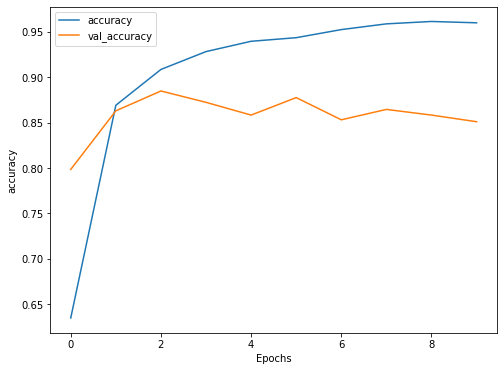

In [94]:
plot_graphs(history, 'accuracy')

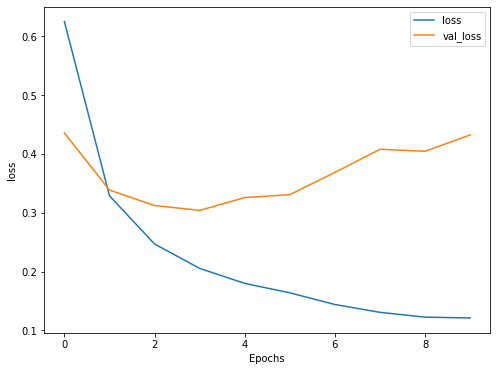

In [95]:
plot_graphs(history, 'loss')

### Stack two or mode LSTM layers
Keras 순환 계층은 `return_sequences` 인자를 통해 2개의 가능한 모드를 가지고 있습니다.
1. 각 시간스텝마다 연속적인 출력의 전체 시퀀스를 반환
2. 입력 시퀀스에 대해 마지막 출력만을 반환

In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [97]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

In [98]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 67s 171ms/step - loss: 0.6221 - accuracy: 0.6368 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 64s 165ms/step - loss: 0.4085 - accuracy: 0.8358 - val_loss: 0.4284 - val_accuracy: 0.8146
Epoch 3/10
391/391 [==============================] - 65s 166ms/step - loss: 0.3194 - accuracy: 0.8828 - val_loss: 0.3793 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 64s 165ms/step - loss: 0.2683 - accuracy: 0.9073 - val_loss: 0.3540 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 65s 166ms/step - loss: 0.2228 - accuracy: 0.9294 - val_loss: 0.3535 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 65s 167ms/step - loss: 0.1949 - accuracy: 0.9410 - val_loss: 0.3608 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 66s 168ms/step - loss: 0.1700 - accuracy: 0.9514 - val_loss: 0.3782 

In [99]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 28s 72ms/step - loss: 0.4987 - accuracy: 0.8381
Test Loss: 0.49873580804566287
Test Accuracy: 0.8380799889564514


In [100]:
# 패딩이 없는 샘플 텍스트 예측
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.17046961]]


In [101]:
# 패딩이 있는 샘플 텍스트 예측
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.02695136]]


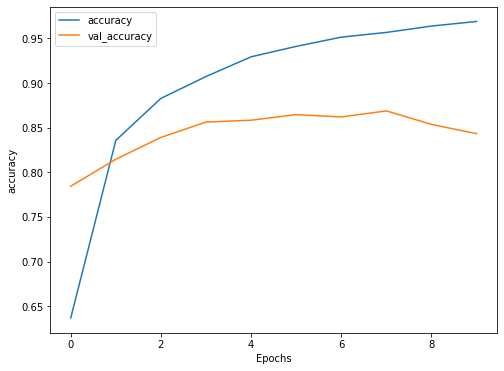

In [102]:
plot_graphs(history, 'accuracy')

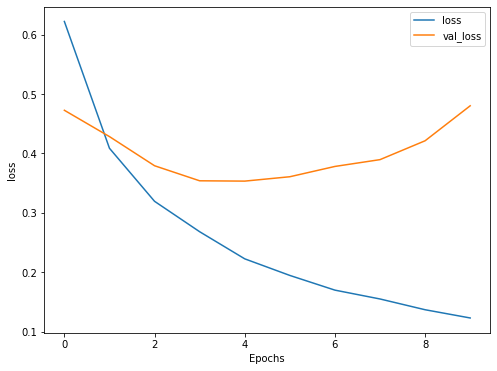

In [103]:
plot_graphs(history, 'loss')